In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
from cleaning_data import clean
from get_macrodata import monthly_data



Текущая рабочая директория: c:\Users\vasil\YandexDisk\project\LK_and_commets 
Оттуда буду брать данные, там должна быть папка data, а в ней данные по годам


c:\Users\vasil\AppData\Local\Programs\Python\Python313\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Users\vasil\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [13]:
monthly_data['spread'] = monthly_data.loc[:, 'ruonia_3m'] - monthly_data.loc[:, 'ruonia']
var_spec = clean(monthly_data.loc[monthly_data.index > dt(2014, 6, 1), ['PMI_manufacturing', 'ru_cpi', 'real_ruonia', 'spread', 'm2x_sa_mom', 'real_brent']])

Это pandas DataFrame!


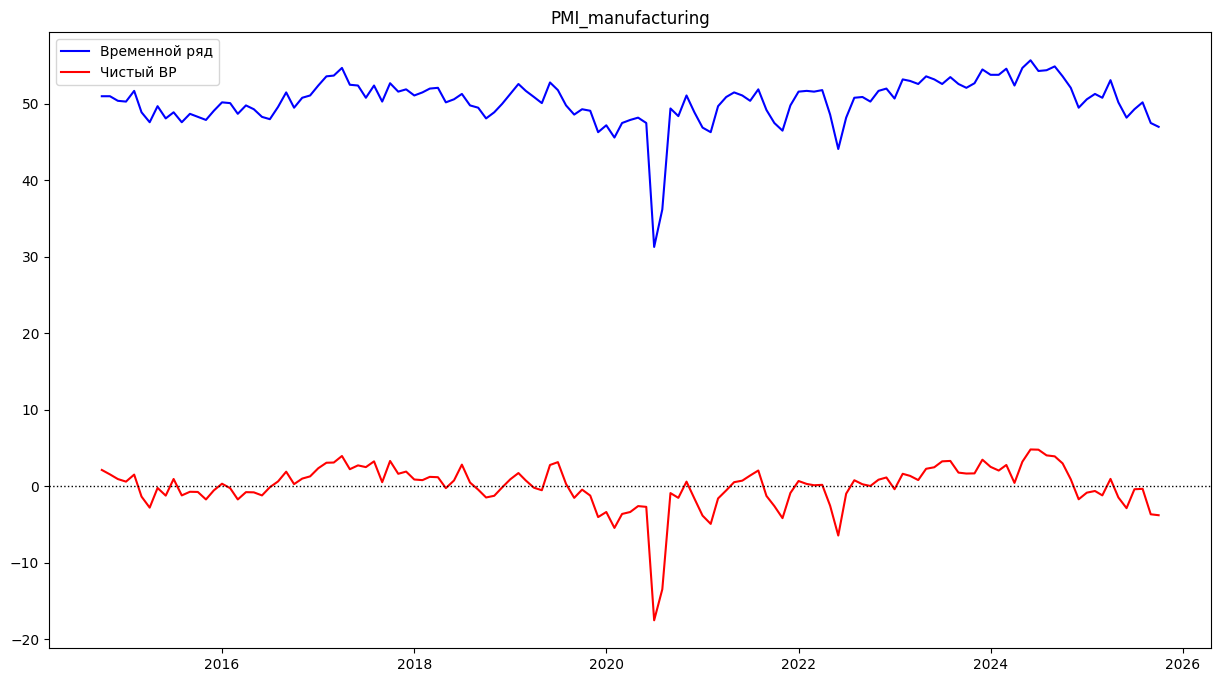

Исходный ряд PMI_manufacturing оказался стационарным


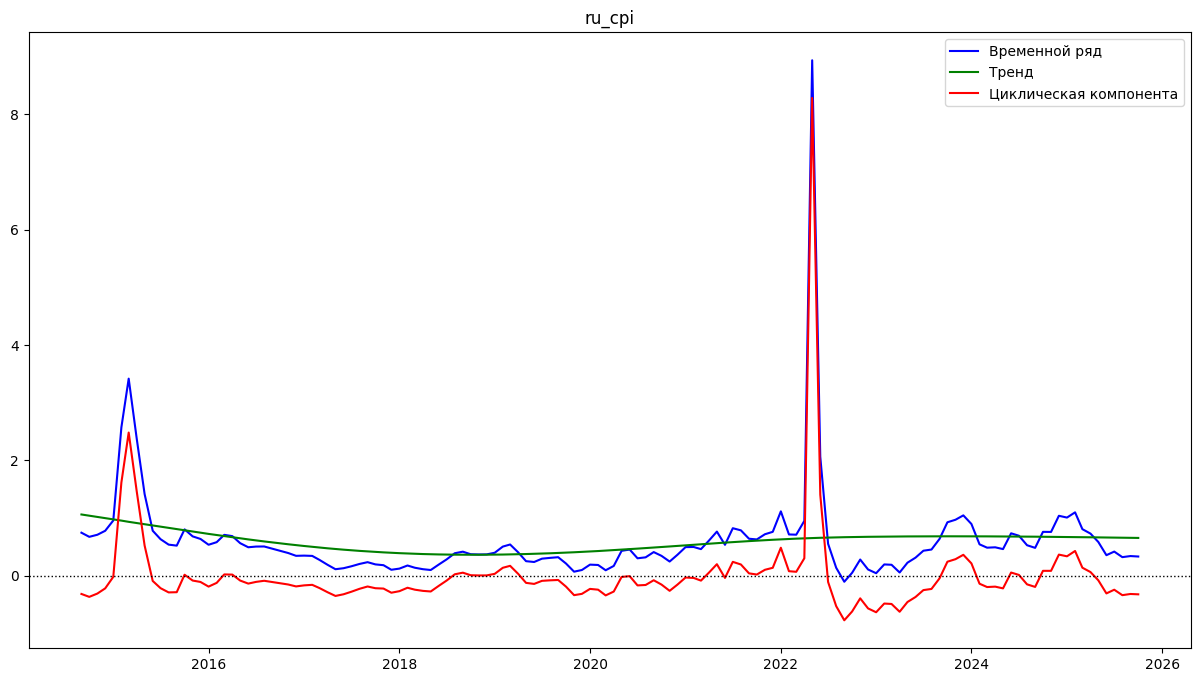

Исходный ряд ru_cpi оказался стационарным


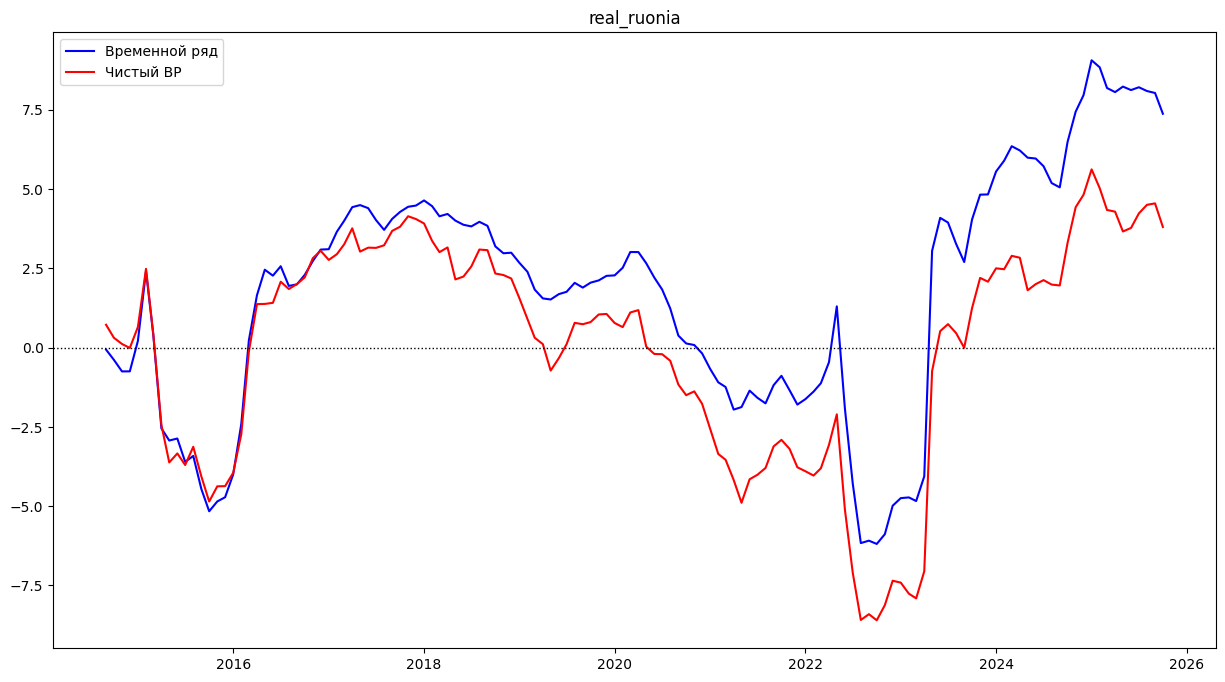

Исходный ряд real_ruonia оказался стационарным


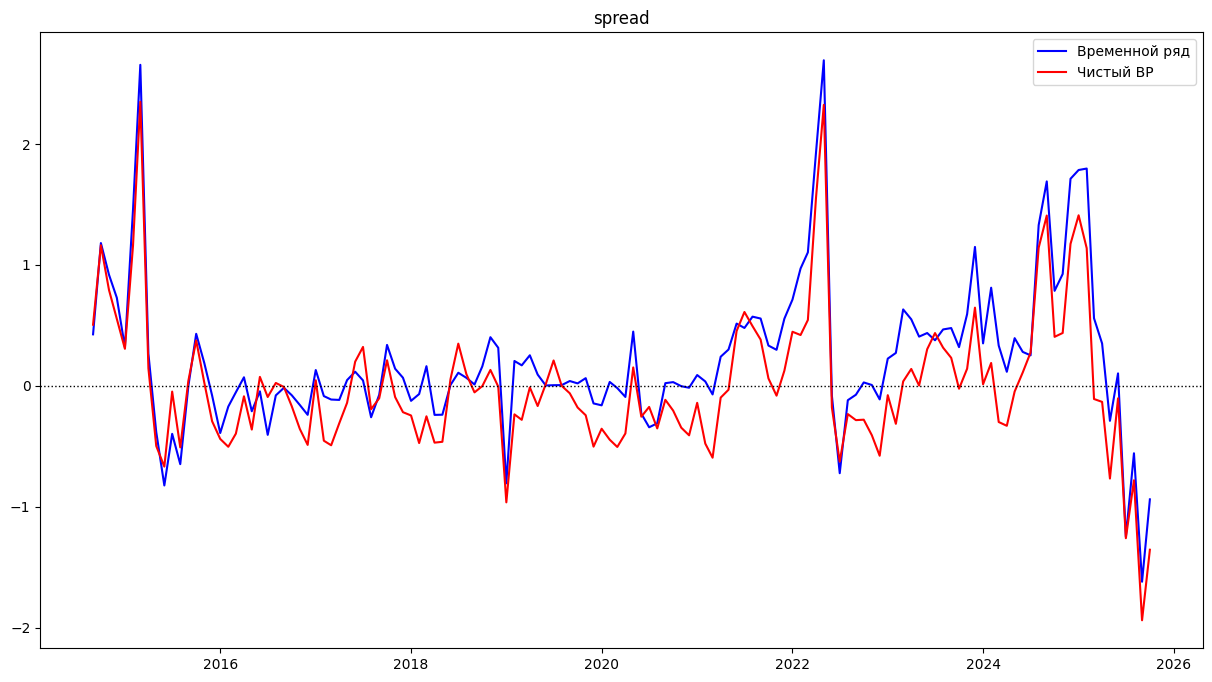

Исходный ряд spread оказался стационарным


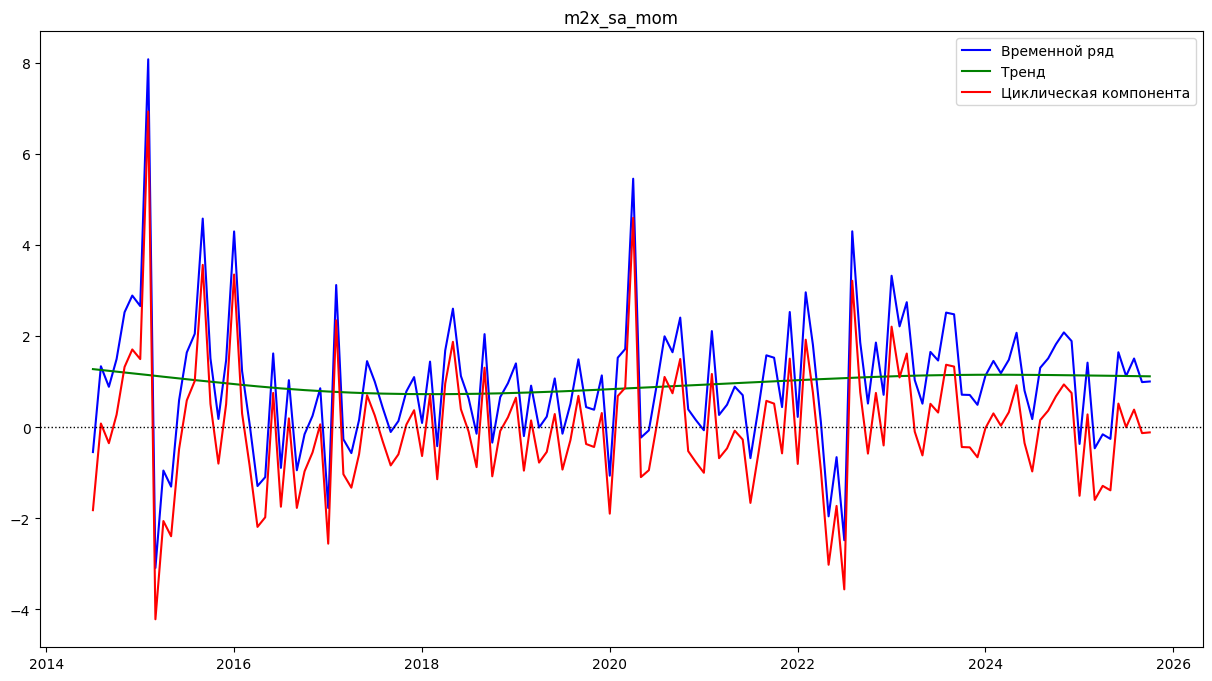

Исходный ряд m2x_sa_mom оказался стационарным


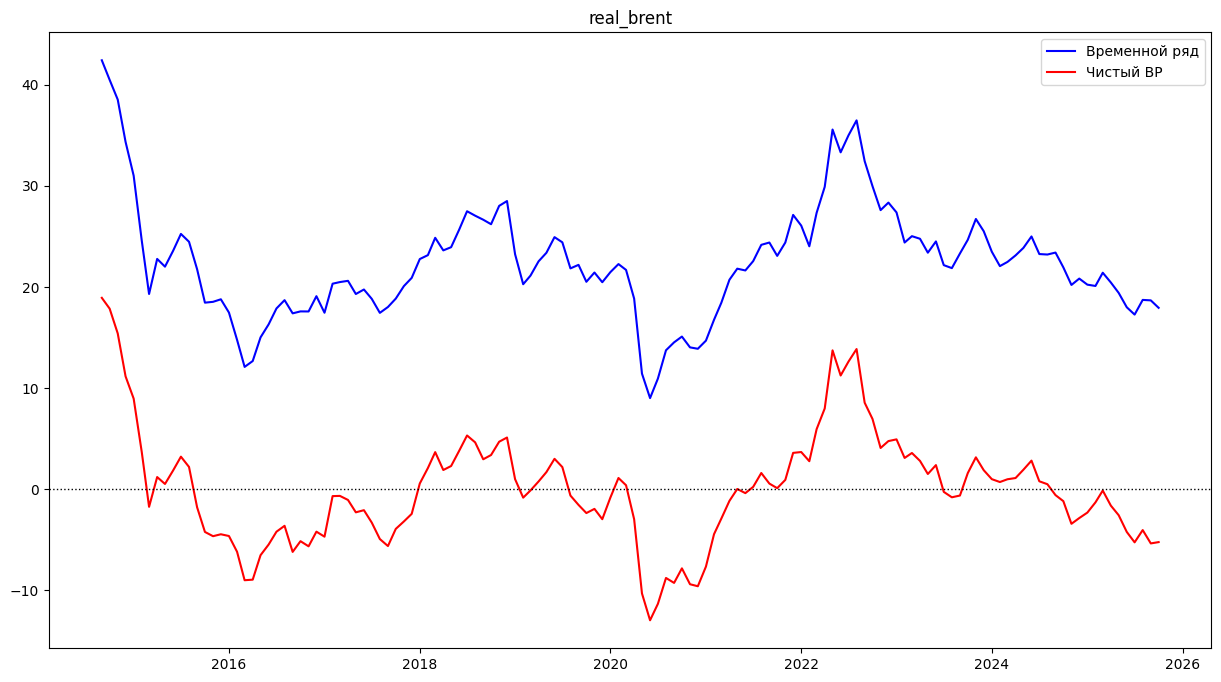

Исходный ряд real_brent оказался стационарным


In [14]:
df, data = var_spec.LOS(use_harmonics=False, only_KPSS = True, hp_filter_map={
                                                                               'ru_cpi': True,
                                                                               'real_rate': False,
                                                                               'm2x_sa_mom': True})
covid_start, duration_covid = (data.T.index < dt(2020, 3, 1)).sum(), 5
svo_start, svo_duration = (data.T.index < dt(2022, 2, 1)).sum(), 2

data = data.T.sort_index(ascending=False).T.copy(deep=True)
data.loc['covid', :] = np.concatenate([np.zeros(data.shape[1]-covid_start-duration_covid), np.ones(duration_covid), np.zeros(covid_start)])
#data.loc['svo', :] = np.concatenate([np.zeros(svo_start), np.ones(svo_duration), np.zeros(data.shape[1]-svo_start-svo_duration)])
data = data.copy(deep = True)

In [4]:
from typing import Optional, Tuple, Union

def OLS_estimation(
                   Nseries, #numpy array
                   lag: int = 1,
                   from_class : bool = True,
                   lag_exog: int = 1,

                   exog_data: Optional[np.ndarray] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int]:

    X = Nseries.values
    p = lag
    K, T = X.shape
    # Основные лаги 
    p_ex = lag_exog
    if exog_data is not None:
        X_ex = exog_data.values
    
    # Основные лаги 
    Z = np.hstack(
        [np.concatenate([np.array([1]), X[:, i:i+p].T.flatten()]).reshape(-1, 1) # type: ignore
            for i in range(T - p)]
    )[:, 1:]
    if exog_data is not None:
        Z_ex = np.hstack(
        [X_ex[:, i:i+p_ex].T.flatten().reshape(-1, 1) # type: ignore
            for i in range(T - p_ex)])[:, 1:]
    
    if exog_data is not None:
        if p > p_ex:
            Z = np.vstack([Z, Z_ex[:, :p_ex-p]])
        elif p == p_ex:
            Z = np.vstack([Z, Z_ex])
        else:
            Z = np.vstack([Z[:, :p-p_ex], Z_ex])
    Y = X[:, :Z.shape[1]]

    B_hat = Y @ Z.T @ np.linalg.inv(Z @ Z.T)
    E = Y - B_hat @ Z
    B_hat_endo = B_hat[:, :K*p+1]
    P = np.linalg.cholesky(E@E.T)
    return Z, Y, B_hat, E, X.shape[0], T, B_hat_endo, P # type: ignore
def irf_companion(
        A_mats : np.ndarray,
        B : np.ndarray, 
        horizon : int
                  ):
    """
    A_mats : list of A_i, i=1..p, каждая (n x n)
    B      : impact matrix (n x n)
    horizon: максимальный лаг
    """
    K = A_mats.shape[0]
    lag = int((A_mats.shape[1])/K)

    # Companion matrix
    
    bottom = np.eye(K*(lag-1), K*lag)
    A_comp = np.vstack([A_mats, bottom])

    # Selector
    J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])

    irfs = []
    for h in range(0, horizon):
        Ah = np.linalg.matrix_power(A_comp, h)
        irfs.append(J @ Ah @ J.T @ B)
    return np.array(irfs)
def random_orthogonal(K):
    Q, _ = np.linalg.qr(np.random.normal(size=(K,K)))
    return Q

In [16]:
K_endo, K_exog, lag, lag_ex = 4, 1, 4, 1

Z, Y, B_hat, E, K, T, B_hat_endo, P = OLS_estimation( # type: ignore
    data.loc[[
    'PMI_manufacturing',
    'ru_cpi',
    'real_ruonia',
    'spread'
       
], :], 
    lag = lag, 
    exog_data = data.loc[[
    'real_brent'
], :],  # type: ignore
    lag_exog=lag_ex)

Найдено матриц: 1000/1000 (100.0%), Использовано симуляций: 4687

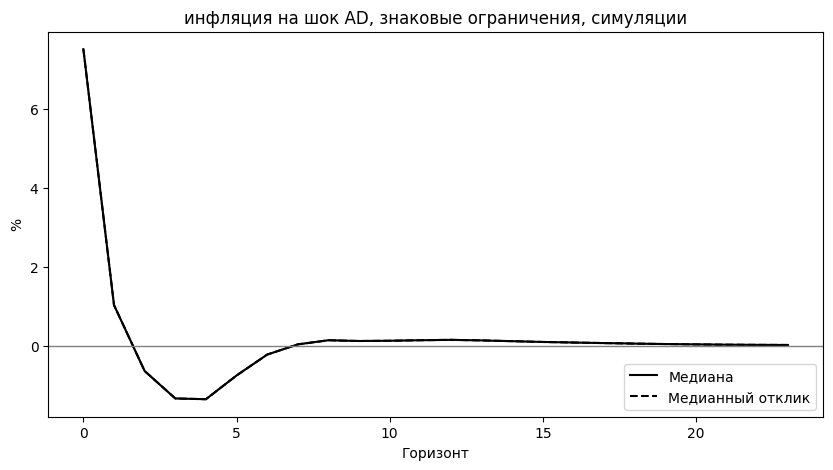

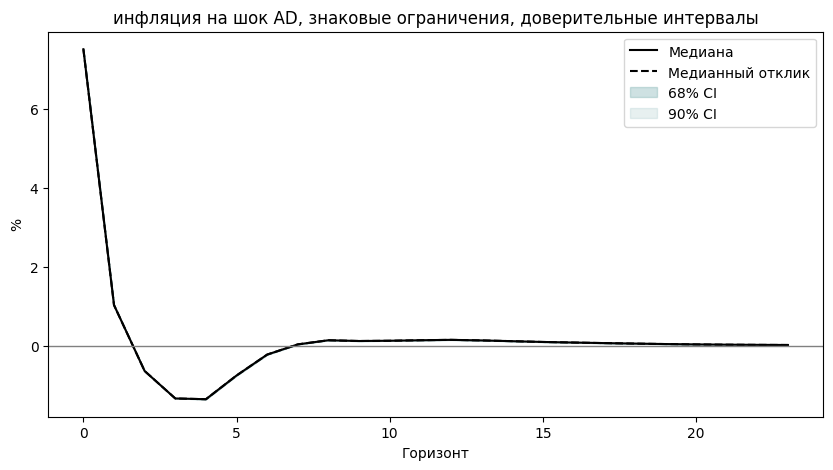

Вероятность, что суммарный отклик положительный 1.0, горизонт 24 мес.
Медианный суммарный отклик  5.61264, горизонт 24 мес.
Верхние 95% суммарный отклик  5.61264, горизонт 24 мес.
Нижние 5% суммарный отклик  5.61264, горизонт 24 мес.


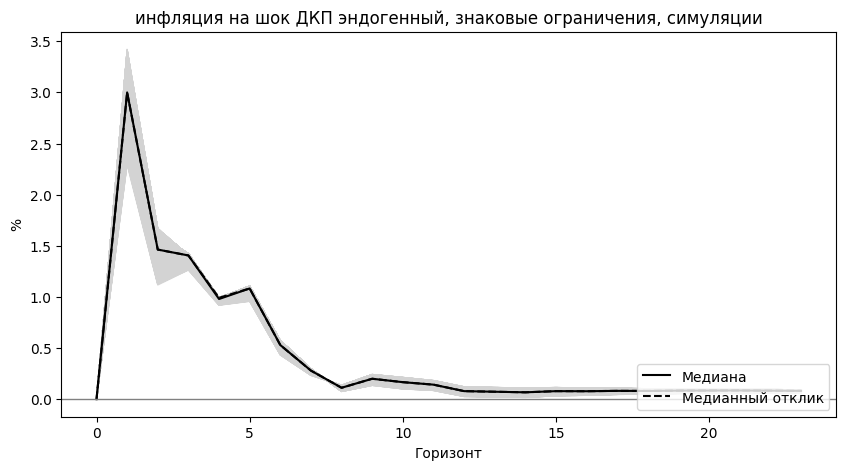

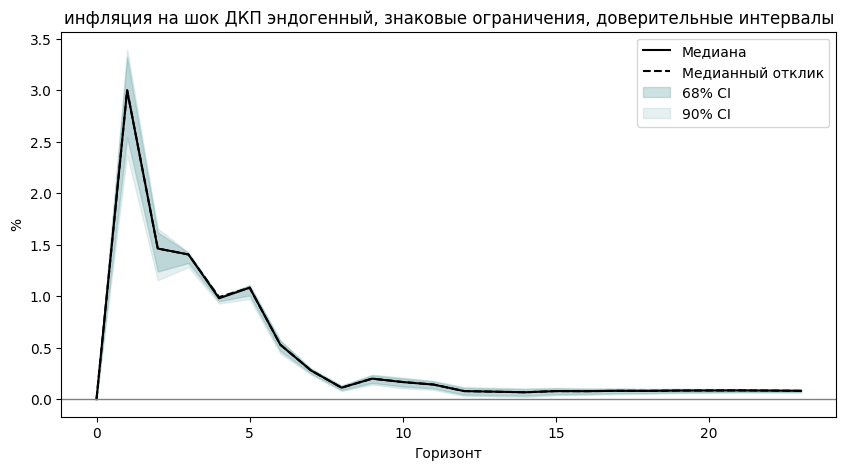

Вероятность, что суммарный отклик положительный 1.0, горизонт 24 мес.
Медианный суммарный отклик  10.3215, горизонт 24 мес.
Верхние 95% суммарный отклик  11.47059, горизонт 24 мес.
Нижние 5% суммарный отклик  8.38244, горизонт 24 мес.


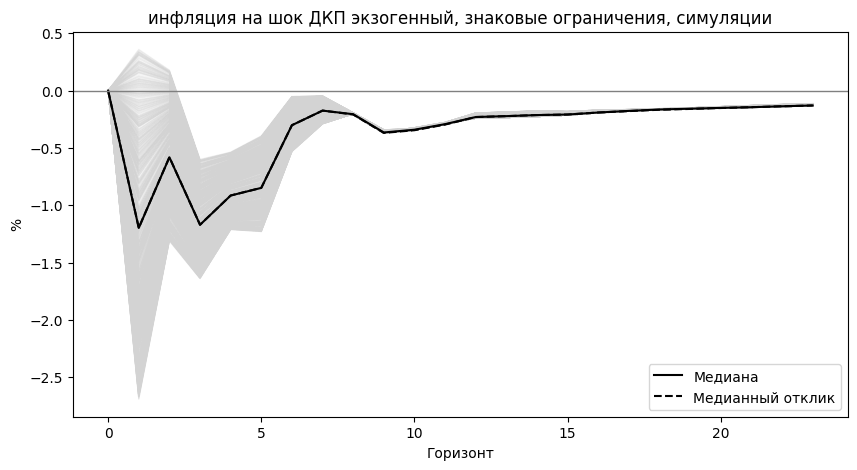

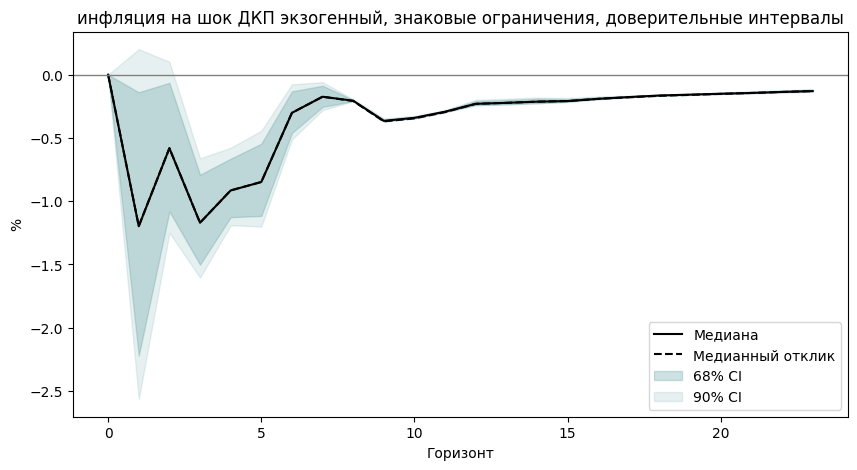

Вероятность, что суммарный отклик положительный 0.0, горизонт 24 мес.
Медианный суммарный отклик  -8.5177, горизонт 24 мес.
Верхние 95% суммарный отклик  -4.56817, горизонт 24 мес.
Нижние 5% суммарный отклик  -12.01088, горизонт 24 мес.


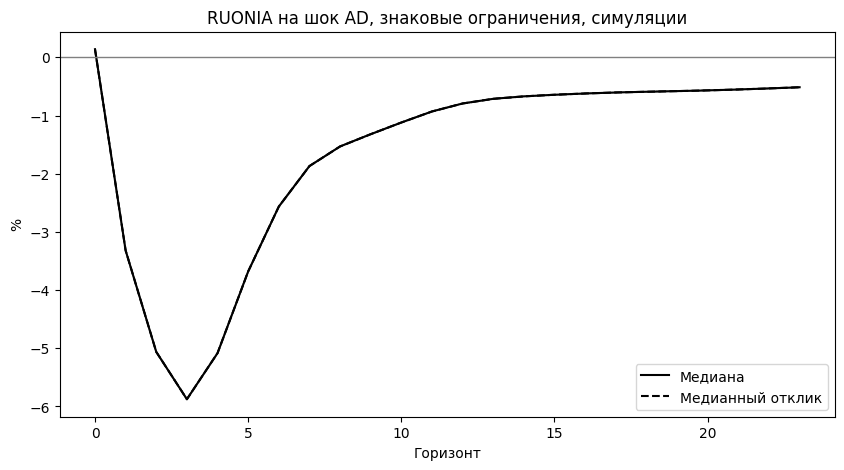

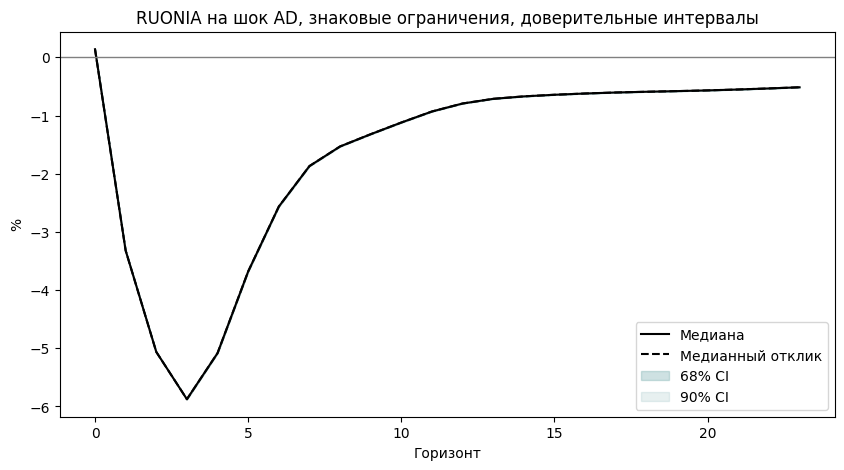

Вероятность, что суммарный отклик положительный 0.0, горизонт 24 мес.
Медианный суммарный отклик  -39.61056, горизонт 24 мес.
Верхние 95% суммарный отклик  -39.61056, горизонт 24 мес.
Нижние 5% суммарный отклик  -39.61056, горизонт 24 мес.


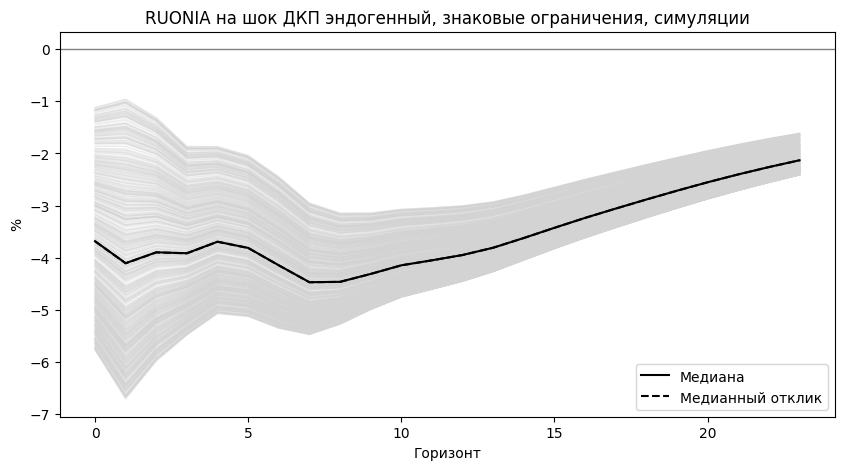

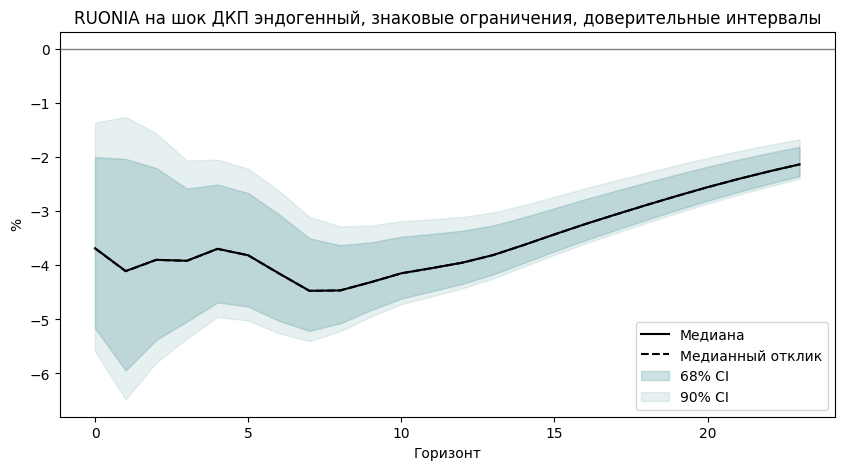

Вероятность, что суммарный отклик положительный 0.0, горизонт 24 мес.
Медианный суммарный отклик  -84.73576, горизонт 24 мес.
Верхние 95% суммарный отклик  -57.58454, горизонт 24 мес.
Нижние 5% суммарный отклик  -103.52217, горизонт 24 мес.


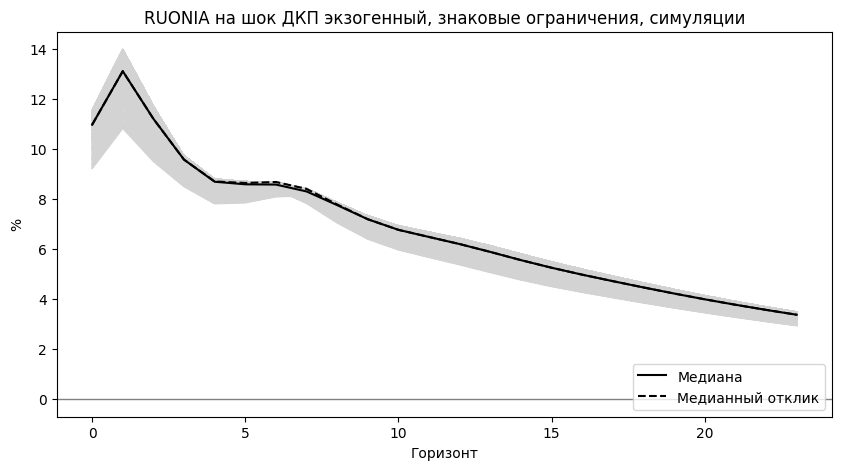

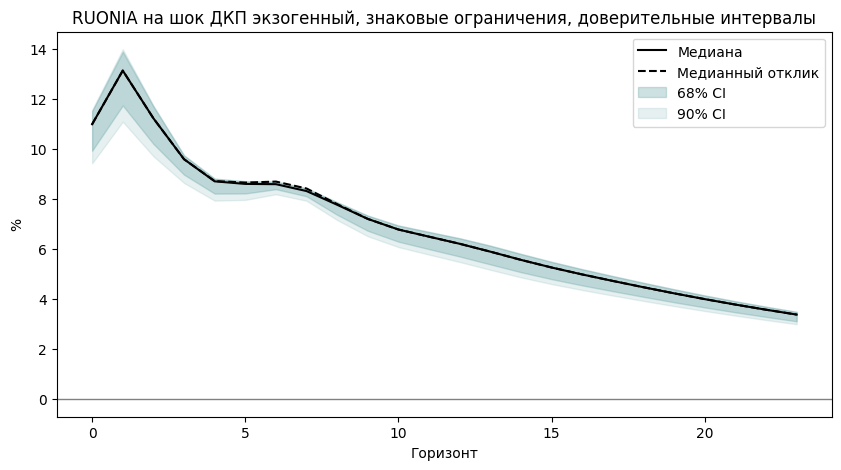

Вероятность, что суммарный отклик положительный 1.0, горизонт 24 мес.
Медианный суммарный отклик  163.36771, горизонт 24 мес.
Верхние 95% суммарный отклик  168.76813, горизонт 24 мес.
Нижние 5% суммарный отклик  145.60826, горизонт 24 мес.


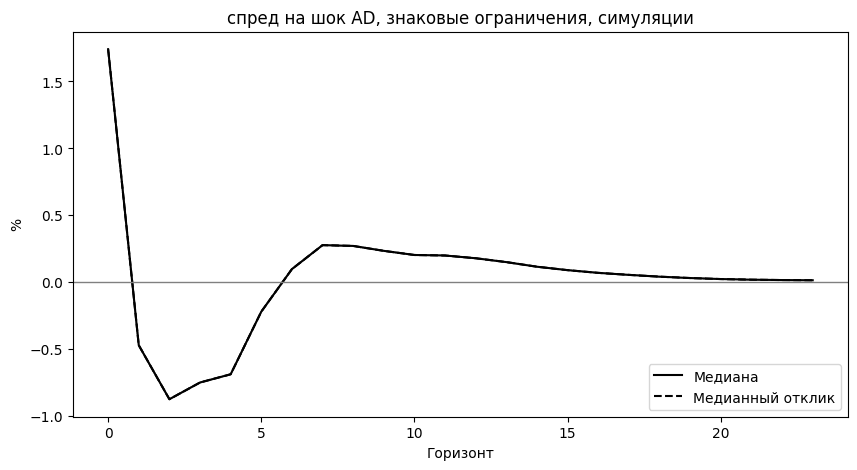

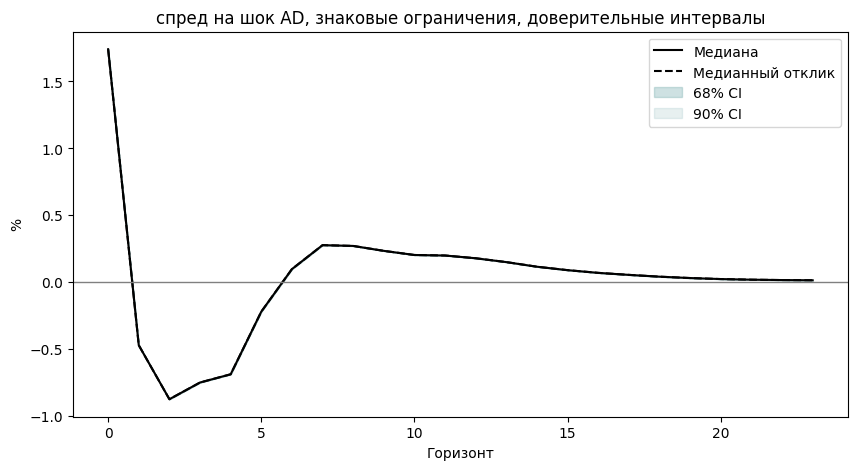

Вероятность, что суммарный отклик положительный 1.0, горизонт 24 мес.
Медианный суммарный отклик  0.85003, горизонт 24 мес.
Верхние 95% суммарный отклик  0.85003, горизонт 24 мес.
Нижние 5% суммарный отклик  0.85003, горизонт 24 мес.


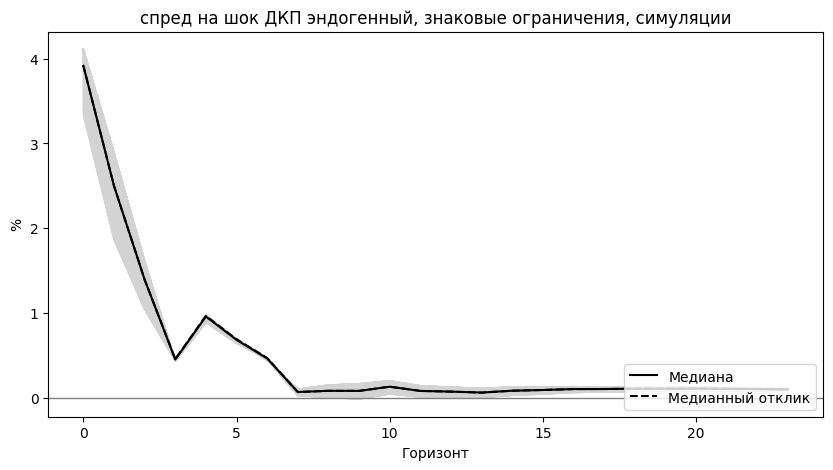

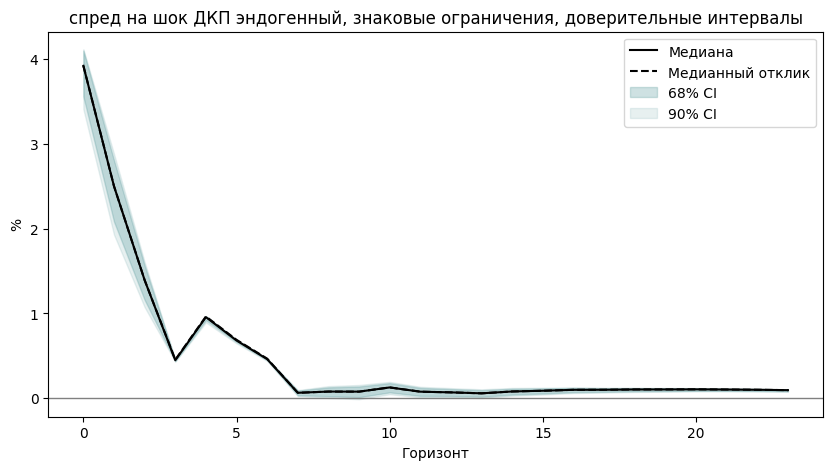

Вероятность, что суммарный отклик положительный 1.0, горизонт 24 мес.
Медианный суммарный отклик  11.90331, горизонт 24 мес.
Верхние 95% суммарный отклик  13.33304, горизонт 24 мес.
Нижние 5% суммарный отклик  9.5969, горизонт 24 мес.


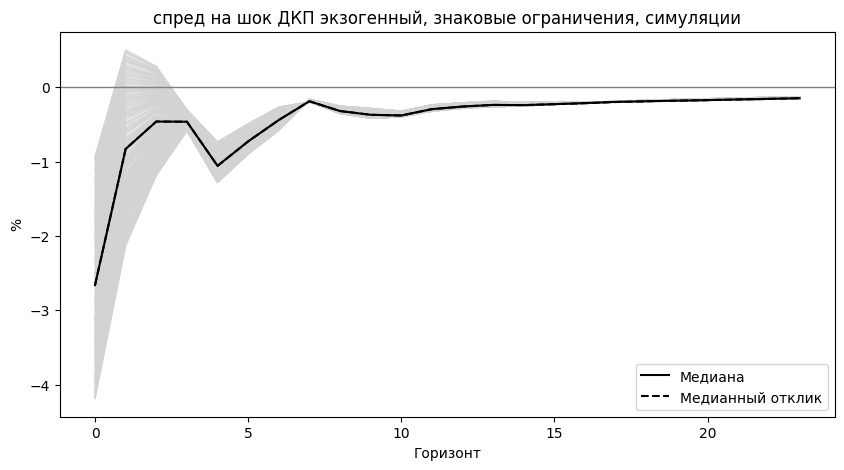

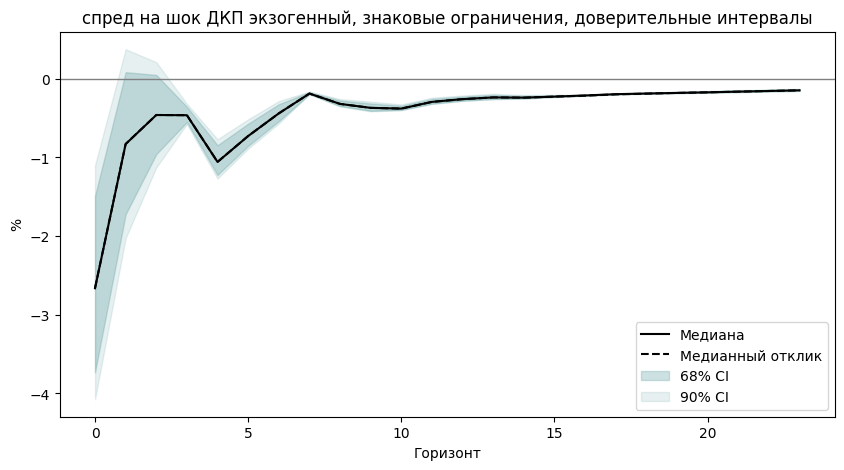

Вероятность, что суммарный отклик положительный 0.0, горизонт 24 мес.
Медианный суммарный отклик  -10.55622, горизонт 24 мес.
Верхние 95% суммарный отклик  -5.76996, горизонт 24 мес.
Нижние 5% суммарный отклик  -14.66759, горизонт 24 мес.


In [ ]:
pluses0 = [
    [4, 3, 4], [4, 4, 3]
]
minuses0 = [
    [3], [3]
]
pluses1 = [
    [], []
]
minuses1 = [
    [], []
]
pluses0= [(np.array(pluses0[0])-1).tolist(), (np.array(pluses0[1])-1).tolist()]
pluses1 = [(np.array(pluses1[0])-1).tolist(), (np.array(pluses1[1])-1).tolist()]
minuses0 = [(np.array(minuses0[0])-1).tolist(), (np.array(minuses0[1])-1).tolist()]
minuses1 = [(np.array(minuses1[0])-1).tolist(), (np.array(minuses1[1])-1).tolist()]
deep = 3
subroatation = True

import sys

required = 1000
np.random.seed(10)
A_mats = B_hat_endo[:, 1:]
lag = int((A_mats.shape[1])/K)

# Companion matrix

bottom = np.eye(K*(lag-1), K*lag)
A_comp = np.vstack([A_mats, bottom])

# Selector
J = np.hstack([np.eye(K), np.zeros((K, K*(lag-1)))])

# number of negative and positive sign restrictions
trans_matrix = np.identity(K)
trans_matrix[2,3] = -1
i = 0
sim = 0
accepted = []
while len(accepted) < required:

    Q = np.identity(K)
    Q_k = random_orthogonal(2)
    Q[2:, 2:] = Q_k
    B_inv = P@ trans_matrix @Q
    irf1 = J @ A_comp @ J.T @ B_inv
    irf2 = J @ np.linalg.matrix_power(A_comp, 2) @ J.T @ B_inv
    cond1 = np.sum(irf1[pluses1[0], pluses1[1]].flatten() > 0) == len(pluses1[0])  and np.sum(irf1[minuses1[0], minuses1[1]].flatten() < 0) == len(minuses1[0])
    cond2 = np.sum(irf2[pluses1[0], pluses1[1]].flatten() > 0) == len(pluses1[0])  and np.sum(irf2[minuses1[0], minuses1[1]].flatten() < 0) == len(minuses1[0])
    cond0 = np.sum(B_inv[pluses0[0], pluses0[1]].flatten() > 0) == len(pluses0[0]) and np.sum(B_inv[minuses0[0], minuses0[1]].flatten() < 0) == len(minuses0[0])
    if cond0 and cond1 and cond2:
        accepted.append(Q)
        i += 1
    sim += 1
    sys.stdout.write(f"\rНайдено матриц: {i}/{required} ({i*100/required:.1f}%), Использовано симуляций: {sim}")
    sys.stdout.flush()
horizon = 24
IRF = []
for Q in accepted:
    IRF.append(irf_companion(B_hat_endo[:, 1:], P@Q@trans_matrix, horizon))
    
u_dict = {0: 'шок AS',
          1: 'шок AD',
          2: 'шок ДКП эндогенный',
          3: 'шок ДКП экзогенный',
          4: 'шок базовый'}
y_dict = {0: 'выпуск',
          1: 'инфляция',
          2: 'RUONIA',
          3: 'спред',
          4: 'Рост М2Х'}
for i, j in [(i+1, j+1) for i in range(1, K_endo) for j in range(1, K_endo)]:
    irf = IRF[0]
    response = [i-1, j-1]
    virf = irf[:, response[0], response[1]]
    
    for irf in IRF[1:]:
        virf = np.vstack([virf, irf[:, response[0], response[1]]])
    median_index = pd.DataFrame((virf - np.median(virf, axis = 0))**2).sum(1).sort_values().index[0]
    import matplotlib.pyplot as plt

    # Имитация матрицы: 10000 симуляций × 20 шагов
    np.random.seed(0)
    responses = virf
    rescale = False
    if rescale:
        depend = data.iloc[response[0]].std()
        shock = data.iloc[response[1]].std()
        virf *= shock/depend
    # Квантили
    median = np.percentile(responses, 50, axis=0)
    lower68 = np.percentile(responses, 16, axis=0)
    upper68 = np.percentile(responses, 84, axis=0)

    lower90 = np.percentile(responses, 5, axis=0)
    upper90 = np.percentile(responses, 95, axis=0)
    med_res = virf[median_index, :]
    median_s = median.sum()
    upper90_s = upper90.sum()
    # Горизонты
    x_axis = np.arange(horizon)
    plt.figure(figsize=(10,5))
    plt.plot(x_axis, virf.T, color="lightgray", alpha=0.2, linewidth=0.8, label="_nolabel_")
    plt.plot(x_axis, median, color='black', label='Медиана')
    
    plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
    plt.axhline(0, color='grey', lw=1)
    plt.xlabel("Горизонт")
    plt.ylabel("%")
    plt.legend(loc = 'lower right')
    plt.title(f"{y_dict[response[0]]} на {u_dict[response[1]]}, знаковые ограничения, симуляции")
    plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(x_axis, median, color='black', label='Медиана')
    
    plt.plot(x_axis, med_res, color='black', ls = '--', label='Медианный отклик')
    plt.fill_between(x_axis, lower68, upper68, color='cadetblue', alpha=0.3, label='68% CI')
    plt.fill_between(x_axis, lower90, upper90, color='cadetblue', alpha=0.15, label='90% CI')
    plt.axhline(0, color='grey', lw=1)
    plt.xlabel("Горизонт")
    plt.ylabel("%")
    plt.legend()
    plt.title(f"{y_dict[response[0]]} на {u_dict[response[1]]}, знаковые ограничения, доверительные интервалы")
    plt.show()
    print(f"Вероятность, что суммарный отклик {'отрицательный' if i == 1 else 'положительный'} {((virf.sum(axis = 1) < 0).sum()/required)\
                                                                         .item() if i == 1 else ((virf.sum(axis = 1) > 0).sum()/required).item()}, горизонт {horizon} мес.")
    print(f"Медианный суммарный отклик  {np.round(np.median(virf, axis = 0).sum(), 5)}, горизонт {horizon} мес.")
    print(f"Верхние 95% суммарный отклик  {np.round(np.quantile(virf, 0.95, axis = 0).sum(), 5)}, горизонт {horizon} мес.")
    print(f"Нижние 5% суммарный отклик  {np.round(np.quantile(virf, 0.05, axis = 0).sum(), 5)}, горизонт {horizon} мес.")

In [7]:
B_inv[pluses0[0], pluses0[1]].flatten()

array([ 3.40605781, 10.31512125])

In [8]:
IRF[999][0, :, :]

array([[23.1562331 ,  0.        ,  0.        ,  0.        ],
       [-1.76927712,  7.52683982,  0.        ,  0.        ],
       [-0.31809208,  0.13939986, -7.76577182,  2.54934943],
       [ 0.35639103, -1.74075255,  0.65384646,  4.05990427]])